In [2]:
#reload module
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
#retina display
%config InlineBackend.figure_format = 'retina'
#matplotlib figures size
plt.rcParams['figure.figsize'] = [5, 2]

import numpy as np
import camb
from camb import model as cmodel
import angularcls
from angularcls import windows, cosmoconstants
import itertools

from scipy import interpolate as interp, integrate as sinteg


In [3]:
nz = 6000 #number of steps to use for the radial/redshift integration
kmax = 100  #kmax to use
#First set up parameters as usual
pars = camb.CAMBparams()

H0 = 67.1
Omegam = 0.315
ommh2 = Omegam*H0**2/100**2
Omegab = 0.049
ombh2 = Omegab*H0**2/100**2
omch2 = ommh2 - ombh2
Omegam = ommh2/(H0/100)**2
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
pars.InitPower.set_params(As = 2.215*1e-9, ns=0.968)

#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results= camb.get_background(pars)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0, chistar, nz)
zs = results.redshift_at_comoving_radial_distance(chis)

Hzs = results.hubble_parameter(zs)

PK = camb.get_matter_power_interpolator(pars, nonlinear = True, 
    hubble_units = False, k_hunit = False, kmax = kmax, k_per_logint = None,
    var1 = 'delta_nonu',var2 = 'delta_nonu', zmax = zs[-1])

PKlin = camb.get_matter_power_interpolator(pars, nonlinear = False, 
    hubble_units = False, k_hunit = False, kmax = kmax, k_per_logint = None,
    var1 = 'delta_nonu',var2 = 'delta_nonu', zmax = zs[-1])

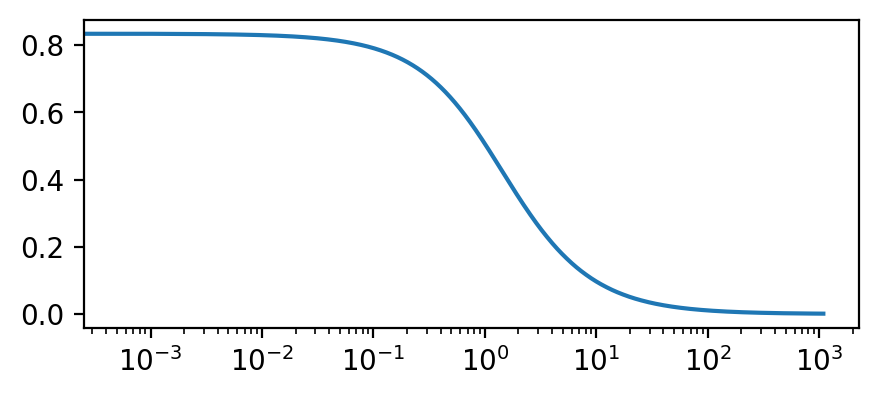

In [4]:
zm, s8 = np.loadtxt('sigma8.txt', unpack = True)
s8 = interp.interp1d(zm, s8, kind = 'cubic', fill_value = 'extrapolate')
plt.plot(zs, s8(zs), label = 'camb')
plt.xscale('log')

In [5]:
Q = lambda x: (4-2**x)/(1+2**(x+1))
 
nonlinearscale = lambda z, k: 4*np.pi*k**3*PKlin.P(z, k)-1

#find root of nonlinearscale(k) = 0 with scipy
from scipy import optimize
kNLz = []
for z in zs:
    nonlinearscale_ = lambda k: nonlinearscale(z, k)
    kstar = optimize.brentq(nonlinearscale_, 1e-5, 1e5)
    kNLz.append(kstar)

kNLzf = interp.interp1d(zs, kNLz, kind = 'cubic', fill_value = 'extrapolate')

In [6]:
import findiff
kgrid = np.log(np.arange(1e-5, 1e5, 1e-2))
Pgrid = np.log(PKlin.P(0, np.exp(kgrid)))
dkgrid = kgrid[1]-kgrid[0]
d2_dx1 = findiff.FinDiff(0, dkgrid, 1)

neff = d2_dx1(Pgrid)
nefff = interp.interp1d(np.exp(kgrid), neff, kind = 'cubic', fill_value = 'extrapolate')

In [7]:
a1, a2, a3, a4 = 0.484, 3.74, -0.849, 0.392
a5, a6, a7, a8, a9 = 1.01, -0.575, 0.128, -0.722, -0.926

In [8]:
afunc = lambda z, k: (1+s8(z)**a6*np.sqrt(0.7*Q(nefff(k)))*(k/kNLzf(z)*a1)**(nefff(k)+a2))/(1+(a1*k/kNLzf(z))**(nefff(k)+a2))
bfunc = lambda z, k: (1+0.2*a3*(nefff(k)+3)*(k/kNLzf(z)*a7)**(nefff(k)+3+a8))/(1+(a7*k/kNLzf(z))**(nefff(k)+3.5+a8))
cfunc = lambda z, k: (1+(4.5*a4/(1.5+(nefff(k)+3)**4)))*(k/kNLzf(z)*a5)**(nefff(k)+3+a9)/(1+(a5*k/kNLzf(z))**(nefff(k)+3.5+a9))

afunc, bfunc, cfunc = lambda z, k: np.ones_like(k), lambda z, k: np.ones_like(k), lambda z, k: np.ones_like(k)

def dot(a, b):
    return np.einsum('ij, ij->j', a, b)

def dot_alt(a, b):
    return np.sum(a*b, axis = 0)
    

def F2ptker_vector(k1vec, k2vec, z):
    """
    Calculates F2 kernel from PT.

    Parameters
    ----------
    k1vec : array_like
        3-vector of k1, shape, (3, n), where n is the number of points to be calculated at.
    k2vec : array_like
        3-vector of k2, shape, (3, n), where n is the number of points to be calculated at.
    z : array_like
        Redshifts, shape, (1, n).
    """
    resultG = 5/7*afunc(np.linalg.norm(k1vec, axis = 0), z)*afunc(np.linalg.norm(k2vec, axis = 0), z)
    k1vec_hat = k1vec/np.linalg.norm(k1vec, axis = 0)[None, :]
    k2vec_hat = k2vec/np.linalg.norm(k2vec, axis = 0)[None, :]
    resultS = bfunc(np.linalg.norm(k1vec, axis = 0), z)*bfunc(np.linalg.norm(k2vec, axis = 0), z)*1/2*(np.linalg.norm(k1vec, axis = 0)/np.linalg.norm(k2vec, axis = 0) + np.linalg.norm(k2vec, axis = 0)/np.linalg.norm(k1vec, axis = 0))*dot(k1vec_hat, k2vec_hat)
    resultT = 2/7*(dot(k1vec_hat, k2vec_hat))**2*cfunc(np.linalg.norm(k1vec, axis = 0), z)*cfunc(np.linalg.norm(k2vec, axis = 0), z)
    return resultG + resultS + resultT
#F2ptker = np.vectorize(F2ptker)

def F2ptker(k1, k2, z):
    resultG = 5/7*afunc(k1, z)*afunc(k2, z)
    k1vec_hat = 1
    k2vec_hat = 1
    resultS = bfunc(k1, z)*bfunc(k2, z)*1/2*(k1/k2 + k2/k1)*np.dot(k1vec_hat, k2vec_hat)
    resultT = 2/7*(np.dot(k1vec_hat, k2vec_hat))**2*cfunc(k1, z)*cfunc(k2, z)
    return (resultG + resultS + resultT)

In [9]:
P = PK.P
def bispectrum_matter_single(k1vec, k2vec, k3vec, z):
    ksvec = [k1vec, k2vec, k3vec]
    combinations = list(itertools.combinations([0,1,2], 2))
    return sum([F2ptker_vector(ksvec[comb[0]], ksvec[comb[1]], z)*P(z, np.linalg.norm(ksvec[comb[0]], axis = 0), grid = False)*P(z, np.linalg.norm(ksvec[comb[1]], axis = 0), grid = False) for comb in combinations])
#bispectrum_matter = np.vectorize(bispectrum_matter_single, signature='(n),(n),(n),(n)->(n)')
bispectrum_matter = bispectrum_matter_single

P = PK.P
def bispectrum_matter_single_alt(k1vec, k2vec, k3vec, z):
    ksvec = [k1vec, k2vec, k3vec]
    combinations = list(itertools.combinations([0,1,2], 2))
    return sum([F2ptker(ksvec[comb[0]], ksvec[comb[1]], z)*P(z, np.linalg.norm(ksvec[comb[0]]), grid = False)*P(z, np.linalg.norm(ksvec[comb[1]]), grid = False) for comb in combinations])

In [10]:
aofchis = 1/(1+zs)

In [11]:
zofchi = interp.interp1d(chis, zs, kind='cubic', fill_value='extrapolate', bounds_error=False)

In [12]:
Wkk = windows.cmblensingwindow_ofchi(chis, aofchis, H0, Omegam, interp1d = True, chistar = chistar)

Wphiphiv = np.nan_to_num(-2*(chistar-chis)/(chistar*chis))
Wphiphiv[0] = 0
Wphiphi = interp.interp1d(chis, Wphiphiv, bounds_error = True)#, fill_value = 'extrapolate')

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_35576/1679819341.py:3: RuntimeWarning: divide by zero encountered in divide
  Wphiphiv = np.nan_to_num(-2*(chistar-chis)/(chistar*chis))


In [13]:
gammav = 3/2*H0**2*Omegam/(cosmoconstants.CSPEEDKMPERSEC**2)/aofchis
gamma = interp.interp1d(chis, gammav, bounds_error = True)#, fill_value = 'extrapolate')

In [14]:
def bispectrum_matter_2d(l1, l2, l3, theta1, theta2, theta3, z):
    l1vec = np.array([l1*np.cos(theta1), l1*np.sin(theta1), np.zeros_like(l1)])
    l2vec = np.array([l2*np.cos(theta2), l2*np.sin(theta2), np.zeros_like(l2)])
    l3vec = np.array([l3*np.cos(theta3), l3*np.sin(theta3), np.zeros_like(l3)])
    return bispectrum_matter(l1vec, l2vec, l3vec, z)

In [15]:
def integrate_bispectrum(l1, l2, l3):
    zeros = np.zeros_like(l1)
    bispectrum_at_ells_of_chi = lambda chi: -chi**2*Wphiphi(chi)**3*gamma(chi)**3/(l1*l2*l3)**2*bispectrum_matter_2d(l1/chi, l2/chi, l3/chi, zeros, zeros, zeros, zofchi(chi))
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, chistar, miniter = 100)[0]

In [16]:
def integrate_bispectrum_quad(l1, l2, l3): 
    bispectrum_at_ells_of_chi = lambda chi: -chi**2*Wphiphi(chi)**3*gamma(chi)**3/(l1*l2*l3)**2*bispectrum_matter_2d(l1/chi, l2/chi, l3/chi, 0/chi, 0/chi, 0/chi, zofchi(chi))
    bispectrum_at_ells_of_chi_wrapped = lambda chi: bispectrum_at_ells_of_chi(np.array([[chi]]))
    return sinteg.quad(bispectrum_at_ells_of_chi, 0, chistar, epsrel = 1e-4)[0]

In [17]:
def integrate_bispectrum_quad_max_z(l, zmax):
    check = lambda chi: zofchi(chi) < zmax
    bispectrum_at_ells_of_chi = lambda chi: check(chi)*-chi**2*Wphiphi(chi)**3*gamma(chi)**3/(l**3)**2*bispectrum_matter_2d(l/chi, l/chi, l/chi, 0, 0, 0, zofchi(chi))
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, chistar, miniter = 100)[0]

In [18]:
ls = np.arange(10, 4000, 10)

Text(0, 0.5, '$\\ell^{6} B_{\\phi \\phi \\phi}(\\ell)$')

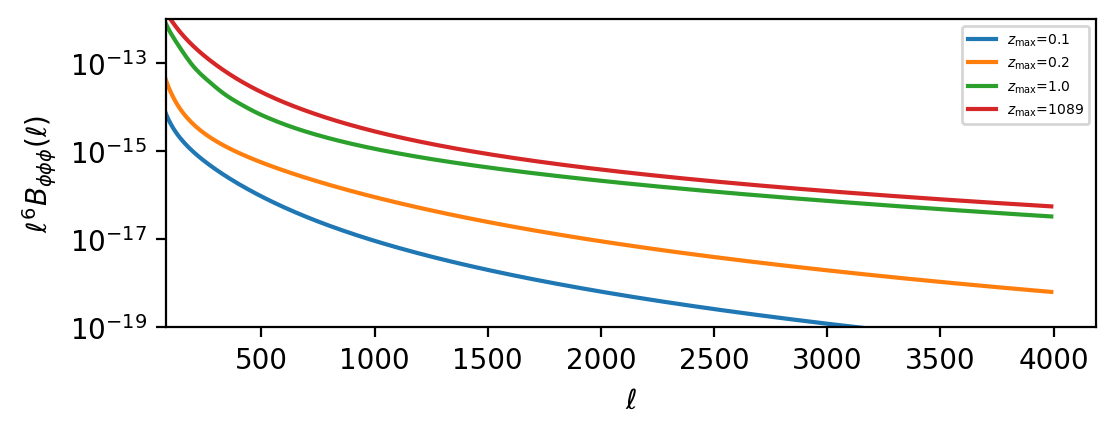

In [19]:
plt.figure(figsize = (6, 2))
for zmax_ in [0.1, 0.2, 1., 1089]:
    temp = lambda l: integrate_bispectrum_quad_max_z(l, zmax_)
    result = list(map(temp, ls))
    plt.plot(ls, result*ls**6, label = fr'$z_{{\rm{{max}}}}$={zmax_}')
plt.legend(fontsize = 5)
plt.xlim(80)
plt.ylim(1e-19, 1e-12)
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^{6} B_{\phi \phi \phi}(\ell)$')

In [20]:
#bispectrum_kappa_single_ell = lambda l: integrate_bispectrum_quad(l, l, l)
#%timeit bls_single_ell_quad = list(map(bispectrum_kappa_single_ell, ls))
#bls_single_ell_quad = list(map(bispectrum_kappa_single_ell, ls))

In [21]:
def integrate_bispectrum(l1, l2, l3):
    zeros = np.zeros_like(l1)
    bispectrum_at_ells_of_chi = lambda chi: -chi**2*Wphiphi(chi)**3*gamma(chi)**3/(l1*l2*l3)**2*bispectrum_matter_2d(l1/chi, l2/chi, l3/chi, zeros, zeros, zeros, zofchi(chi))
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, chistar, miniter = 200)[0]

bispectrum_kappa_single_ell = lambda l: integrate_bispectrum(l, l, l)
%timeit bls_single_ell = list(map(bispectrum_kappa_single_ell, ls))
bls_single_ell = np.array(list(map(bispectrum_kappa_single_ell, ls)))

409 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
#np.array(bls_single_ell*ls**6)
#interesting numpy resolution small numbers

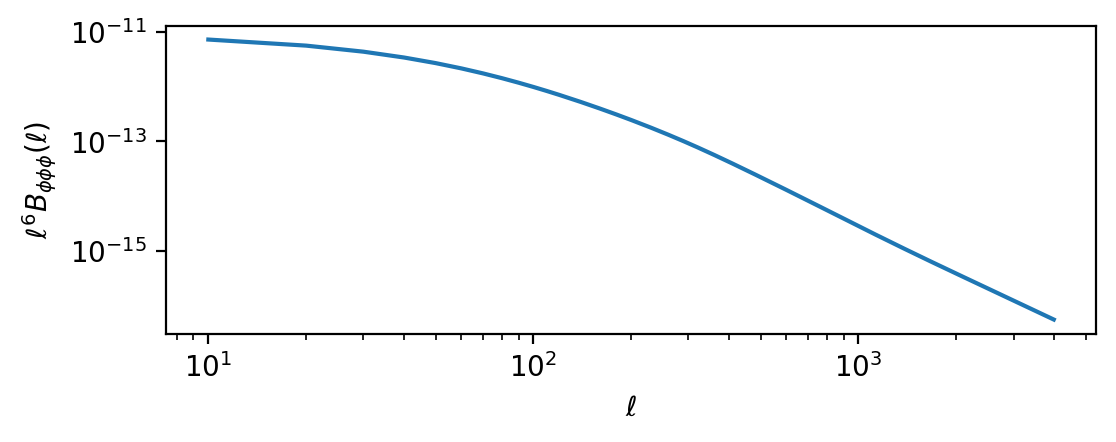

In [23]:
plt.figure(figsize = (6, 2))
plt.plot(ls, bls_single_ell*ls**6)
#plt.plot(ls, bls_single_ell_quad*ls**6, ls = '--')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^{6} B_{\phi \phi \phi}(\ell)$')
plt.xscale('log')
#plt.ylim(1e-17, 1e-15)

In [24]:
def integrate_bispectrum_with_angles(l1, l2, l3, theta1, theta2, theta3):
    bispectrum_at_ells_of_chi = lambda chi: -chi**2*Wphiphi(chi)**3*gamma(chi)**3/(l1*l2*l3)**2*bispectrum_matter_2d(l1/chi, l2/chi, l3/chi, theta1, theta2, theta3, zofchi(chi))
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, chistar, miniter = 10)[0]

In [25]:
ells = np.concatenate([np.arange(1, 100, 2), np.logspace(2, 3, 30), np.logspace(np.log10(1000), np.log10(4000), 40)])
ells = np.unique(ells)

thetas = np.linspace(0, 2*np.pi, 20)

#ells = np.logspace(np.log10(1000), np.log10(4000), 100)

In [26]:
#X, Y, Z, thetaX, thetaY, thetaZ = np.meshgrid(ells, ells, ells, thetas, thetas, thetas)
#X, Y, Z = np.meshgrid(ells, ells, ells)


In [27]:
import itertools

ells = np.concatenate([np.arange(1, 100, 2), np.logspace(2, 3, 30), np.logspace(np.log10(1000), np.log10(4000), 40)])
ells = np.unique(ells)

thetas = np.linspace(0, 2*np.pi, 5)

combs_ells = itertools.combinations_with_replacement(ells, 3)
combs_thetas = itertools.combinations_with_replacement(thetas, 3)

bispectrum_calculated = [integrate_bispectrum(*x) for x in combs_ells]

#bispectrum_calculated = [integrate_bispectrum_with_angles(*x, *y) for x, y in zip(combs_ells, combs_thetas)]

In [28]:
from sympy.utilities.iterables import multiset_permutations

In [29]:
results = []
inputsX = []
inputsY = []
inputsZ = []

unico = []

results = np.zeros((len(ells), len(ells), len(ells)))

ells_list = list(ells)

for i, x in enumerate(itertools.combinations_with_replacement(ells, 3)):
    y = multiset_permutations(x)
    for z in y:
        inputsX += [z[0]]
        inputsY += [z[1]]
        inputsZ += [z[2]]
        A, B, C = [ells_list.index(z[ii]) for ii in range(3)]
        results[A, B, C] = bispectrum_calculated[i]
        if len(set(z)) == 1:
            unico += [bispectrum_calculated[i]]

inputsX = np.array(inputsX)
inputsY = np.array(inputsY)
inputsZ = np.array(inputsZ)
results *= ells[:, None, None]**6

In [30]:
from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((ells, ells, ells), results, bounds_error = False, fill_value = 0)
interp_new = lambda l1, l2, l3: interp((l1, l2, l3))/l1**6

In [31]:
#bispectrum_calculated = np.array(bispectrum_calculated)
#np.save('bispectrum_calculated_phi.npy', bispectrum_calculated)
#bispectrum_calculated = np.load('bispectrum_calculated_phi.npy')

Text(0, 0.5, '$\\ell^{6} B_{\\phi \\phi \\phi}(\\ell)$')

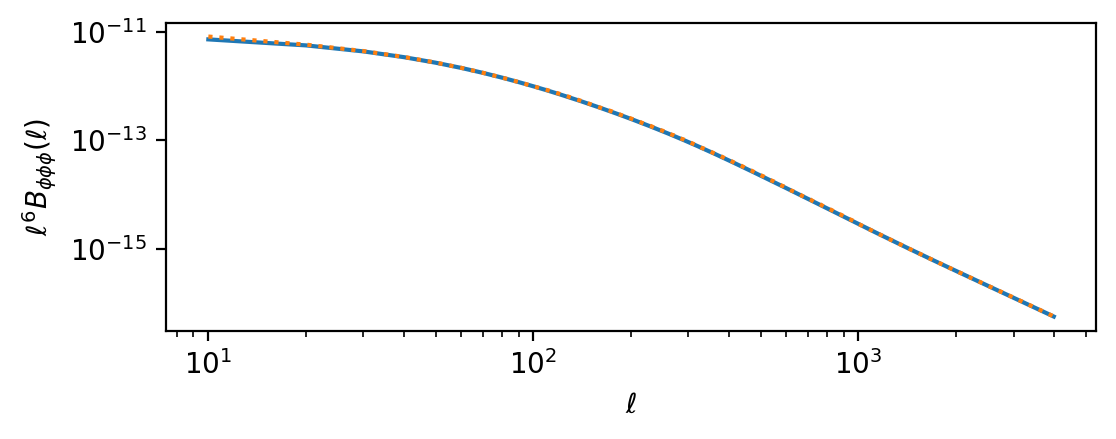

In [32]:
bispectrum_interp = interp_new#RegularGridInterpolator((ells, ells, ells), bispectrum_calculated*X**6, bounds_error = False, fill_value = 0)

bispectrum_interp_single = lambda l: bispectrum_interp(l, l, l)
bls_single_ell_single_calc = list(map(bispectrum_interp_single, ls))

plt.figure(figsize = (6, 2))
plt.plot(ls, bls_single_ell*ls**6)
#plt.plot(ls, bls_single_ell_quad*ls**6, ls = '--')
plt.loglog(ls, bls_single_ell_single_calc*ls**6, ls = ':')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^{6} B_{\phi \phi \phi}(\ell)$')

### Setting Up CMB part

In [44]:
import camb
import symlens as s
from pixell import enmap, utils as putils
import numpy as np

In [46]:
potential_file = "lensedCMB_dmn1_lenspotentialCls.dat"
d = np.loadtxt(f'/Users/omard/Documents/projects/fgcmblensing/input/giulio/{potential_file}')
l = d[:, 0]
dd = d[:, 5]
kk = 2*np.pi*dd/4
pp = 4/l**2/(l+1)**2*kk

TCMB = 2.73e6

dd = np.loadtxt('/Users/omard/Documents/projects/fgcmblensing/input/giulio/lensedCMB_dmn1_lensedgradCls.dat')

d = np.loadtxt('/Users/omard/Documents/projects/fgcmblensing/input/giulio/lensedCMB_dmn1_lensedCls.dat')
L, TT = d[:, 0], d[:, 1]
lfact = 2*np.pi/L/(L+1)
TT *= lfact#/TCMB**2.


get_noise = lambda x, level, theta: (level*np.pi/180/60)**2*np.exp(x*(x+1)*np.deg2rad(theta / 60)**2/8/np.log(2))

shape,wcs = enmap.geometry(shape=(512,512),res=2.0*putils.arcmin,pos=(0,0))

modlmap = enmap.modlmap(shape,wcs)

f = s.Ldl1 * s.e('uC_T_T_l1') + s.Ldl2 * s.e('uC_T_T_l2')

F = f / 2 / s.e('tC_T_T_l1') / s.e('tC_T_T_l2')

expr1 = f * F

fsky = 0.4
noise, beam = 1., 1.

feed_dict = {}
feed_dict['uC_T_T'] = s.interp(L,TT)(modlmap)
feed_dict['tC_T_T'] = s.interp(L,TT)(modlmap)+s.interp(L,get_noise(L, noise, beam))(modlmap)

tellmin = 100
tellmax = 3500
xmask = s.mask_kspace(shape,wcs,lmin=tellmin,lmax=tellmax)
integral = s.integrate(shape,wcs,feed_dict,expr1,xmask=xmask,ymask=xmask).real
Alphi = 1/integral

bin_edges = np.arange(10,3000,40)
binner = s.bin2D(modlmap,bin_edges)
A_l = Alphi

cents, AL1D = binner.bin(A_l)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_35576/3373329273.py:41: RuntimeWarning: divide by zero encountered in divide
  Alphi = 1/integral


In [47]:
lmin, lmax = tellmin, tellmax
selection = (L >= lmin) & (L <= lmax)

In [48]:
import scipy as sp

uTT = sp.interpolate.interp1d(L[selection], TT[selection], fill_value = 0., bounds_error = False)
tTT = sp.interpolate.interp1d(L[selection], TT[selection]+get_noise(L, noise, beam)[selection], fill_value = 1e5, bounds_error = False)

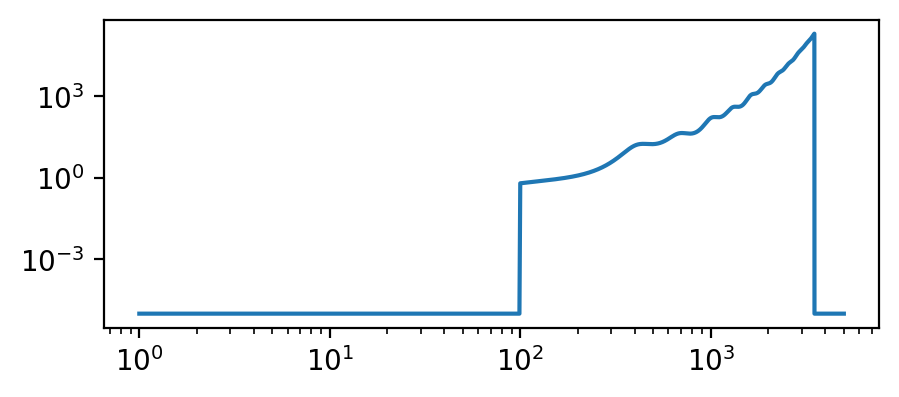

In [49]:
l_ = np.arange(1, 5000, 1)
plt.loglog(l_, 1/tTT(l_))

In [50]:
def dot(a, b):
    return np.einsum('ab, ab -> b', a, b)

    
def fTT(l1v, l2v):
    return dot(l1v+l2v, l1v)*uTT(np.linalg.norm(l1v, axis = 0))+dot(l1v+l2v, l2v)*uTT(np.linalg.norm(l2v, axis = 0))

def ftotTT(l):
    return tTT(l)

def g(lv, Lv):
    l1v, l2v = lv, Lv[:, None]-lv
    return fTT(l1v, l2v)/(2*ftotTT(np.linalg.norm(l1v))*ftotTT(np.linalg.norm(l2v)))

In [51]:
Ls = np.arange(5, 3000, 10)

In [40]:
Rparallel = []
for L in Ls:
    Lvec = np.array([L, 0])
    integrand = lambda l, theta: g(np.array([l*np.cos(theta), l*np.sin(theta)]), Lvec)*np.cos(theta)**2*uTT(l)*l**2
    l_temp = np.arange(lmin, lmax, 3)
    integrand_temp = []
    thetas = np.linspace(0, 2*np.pi, 100)
    for l_ in l_temp:
        integrand_temp_function = lambda theta: integrand(l_, theta)
        temp = np.array(integrand_temp_function(thetas))
        integrand_temp.append(sp.integrate.simpson(temp, thetas))
    integrand_temp_interp = sp.interpolate.interp1d(l_temp, integrand_temp, fill_value = 0., bounds_error = False)
    out_integrand = lambda l: integrand_temp_interp(l)*l
    Rparallel.append(sp.integrate.simpson(out_integrand(l_temp), l_temp))
    #Rparallel.append(sp.integrate.quadrature(out_integrand, lmin, lmax, miniter = 2000)[0])

In [41]:
betaparallel = []
for L in Ls:
    Lvec = np.array([L, 0])
    integrand = lambda l, theta: bispectrum_interp(l, np.linalg.norm(np.array([L-l*np.cos(theta), -l*np.sin(theta)])), L)*np.cos(theta)*(l*np.cos(theta)-L)
    l_temp = np.arange(10, 3000, 3)
    integrand_temp = []
    for l_ in l_temp:
        integrand_temp_function = np.vectorize(lambda theta: integrand(l_, theta))
        temp = np.array(integrand_temp_function(thetas))
        integrand_temp.append(sp.integrate.simpson(temp, thetas))
        #integrand_temp.append(sp.integrate.quadrature(integrand_temp_function, 0, 2*np.pi, miniter = 1000)[0])
    integrand_temp_interp = sp.interpolate.interp1d(l_temp, integrand_temp, fill_value = 0., bounds_error = False)
    out_integrand = lambda l: integrand_temp_interp(l)*l**2
    betaparallel.append(sp.integrate.simpson(out_integrand(l_temp), l_temp))
    #betaparallel.append(sp.integrate.quadrature(out_integrand, lmin, lmax, miniter = 1000)[0])

In [42]:
betaparallel

[-1.6019061442403565e-12,
 -1.258440021959714e-13,
 -3.3227551026543156e-14,
 -1.3145862098193393e-14,
 -6.9678675192462164e-15,
 -3.5458864838142702e-15,
 -1.9338842513645998e-15,
 -1.4713175124527217e-15,
 -8.976020660445464e-16,
 -5.455029527460228e-16,
 -5.139616976255057e-16,
 -3.3213325402496214e-16,
 -2.0938284945168652e-16,
 -2.2719888011758137e-16,
 -1.4993358619482137e-16,
 -9.347965406220005e-17,
 -1.1682929089482205e-16,
 -7.623075677249681e-17,
 -4.605073766243421e-17,
 -6.709497026182502e-17,
 -4.283817178410847e-17,
 -2.433273902419419e-17,
 -4.13252300625426e-17,
 -2.6023962828173967e-17,
 -1.3309941894566415e-17,
 -2.7323757431351223e-17,
 -1.651412182406156e-17,
 -7.612816135743712e-18,
 -1.8729292628797945e-17,
 -1.1003706046045362e-17,
 -4.2224392275539895e-18,
 -1.3532838408942231e-17,
 -7.528285575014012e-18,
 -2.3594007759148156e-18,
 -1.0039400339545374e-17,
 -5.2970646455970456e-18,
 -1.2390725329218206e-18,
 -7.644213408764637e-18,
 -3.839034389472884e-18,
 -5

[ 1.38363640e-06  7.05252559e-07  4.24502989e-07  2.29604885e-07
  1.16519737e-07  5.25918352e-08  1.40251574e-08  1.65109279e-09
  1.01151793e-09  5.29626946e-10  2.34403053e-10  1.04280113e-10
  6.38743546e-11  3.34220333e-11  1.74929327e-11  8.29619077e-12
  4.87569118e-12  2.19665033e-12  7.45089419e-13  1.19689670e-14
 -1.69336116e-13 -1.62447707e-13 -1.13789169e-13 -7.76091562e-14
 -5.19115033e-14 -3.40932781e-14 -2.02815980e-14 -1.16620093e-14
 -7.62913429e-15 -4.00662157e-15 -1.41473132e-15 -4.22605528e-16
 -1.16351663e-16 -5.27513340e-18 -4.85275078e-24 -3.92647725e-24
 -3.20425807e-24 -2.51585511e-24 -1.80615783e-24 -1.00199351e-24
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000

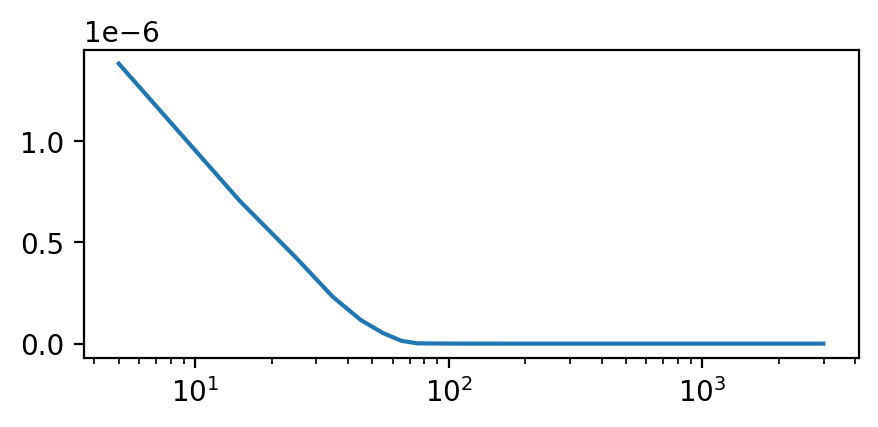

In [ ]:
NC1 = -4*AL**2*SLapprox*betaparallel*Rparallel
plt.plot(Ls, NC1, label = 'NC1')
plt.xscale('log')

In [373]:
AL = np.interp(Ls, cents, AL1D)
SLapprox = 1/(2*AL)

In [374]:
Rparallel = np.array(Rparallel)
betaparallel = np.array(betaparallel)

In [375]:
Rperpendicular = []
for L in Ls:
    Lvec = np.array([L, 0])
    integrand = lambda l, theta: g(np.array([l*np.cos(theta), l*np.sin(theta)]), Lvec)*l**2*np.sin(theta)**2*uTT(l)
    l_temp = np.arange(10, 3000, 3)
    integrand_temp = []
    for l_ in l_temp:
        integrand_temp_function = lambda theta: integrand(l_, theta)
        temp = np.array(integrand_temp_function(thetas))
        integrand_temp.append(sp.integrate.simpson(temp, thetas))
        #integrand_temp.append(sp.integrate.quadrature(integrand_temp_function, 0, 2*np.pi, miniter = 1000)[0])
    integrand_temp_interp = sp.interpolate.interp1d(l_temp, integrand_temp, fill_value = 0., bounds_error = False)
    out_integrand = lambda l: integrand_temp_interp(l)*l
    Rperpendicular.append(sp.integrate.simpson(out_integrand(l_temp), l_temp))
    #Rperpendicular.append(sp.integrate.quadrature(out_integrand, lmin, lmax, miniter = 2000)[0])

In [376]:
betaperpendicular = []
for L in Ls:
    Lvec = np.array([L, 0])
    integrand = lambda l, theta: bispectrum_interp(l, np.linalg.norm(np.array([L-l*np.cos(theta), -l*np.sin(theta)])), L)*np.sin(theta)**2
    l_temp = np.arange(10, 3000, 3)
    integrand_temp = []
    for l_ in l_temp:
        integrand_temp_function = lambda theta: integrand(l_, theta)
        temp = np.array(integrand_temp_function(thetas))
        integrand_temp.append(sp.integrate.simpson(temp, thetas))
        #integrand_temp.append(sp.integrate.quadrature(integrand_temp_function, 0, 2*np.pi, miniter = 1000)[0])
    integrand_temp_interp = sp.interpolate.interp1d(l_temp, integrand_temp, fill_value = 0., bounds_error = False)
    out_integrand = lambda l: integrand_temp_interp(l)*l**3
    betaperpendicular.append(sp.integrate.simpson(out_integrand(l_temp), l_temp))
    #betaperpendicular.append(sp.integrate.quadrature(out_integrand, lmin, lmax, miniter = 1000)[0])

In [377]:
Rperpendicular, betaperpendicular = np.array(Rperpendicular), np.array(betaperpendicular)

In [384]:
total = Rparallel*betaparallel+Rperpendicular*betaperpendicular

In [385]:
AL = np.interp(Ls, cents, AL1D)
SLapprox = 1/(2*AL)

[ 1.49394024e-06  7.60609108e-07  4.56767040e-07  2.44836642e-07
  1.23664784e-07  5.54791400e-08  1.46658201e-08  1.69960425e-09
  1.02949934e-09  5.30009096e-10  2.28908013e-10  9.91221299e-11
  5.85684034e-11  2.89209763e-11  1.41531110e-11  5.92522333e-12
  2.95871506e-12  7.83367926e-13 -2.26561849e-13 -6.61109456e-13
 -6.32254447e-13 -4.87306881e-13 -3.05296436e-13 -1.99098272e-13
 -1.24966386e-13 -8.01820916e-14 -4.45145388e-14 -2.36564539e-14
 -1.40528434e-14 -6.69606757e-15 -2.35107867e-15 -6.99398815e-16
 -1.98296779e-16 -1.00794540e-17 -8.98491168e-24 -7.04176047e-24
 -5.57279636e-24 -4.24015959e-24 -2.94925685e-24 -1.59150424e-24
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000

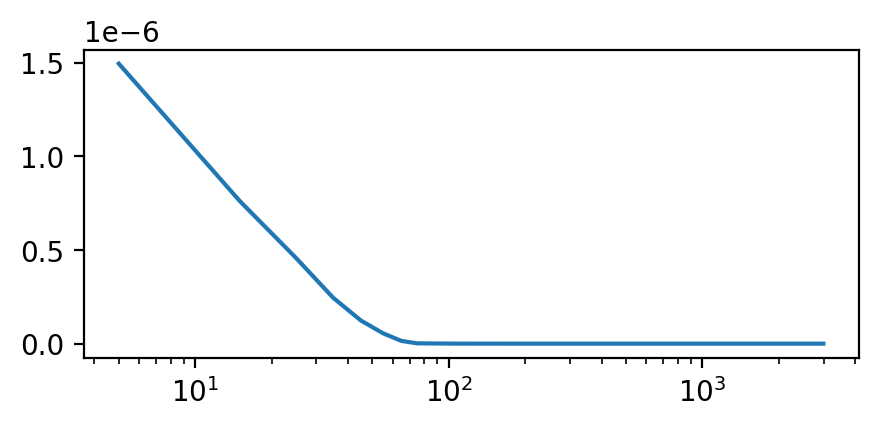

In [386]:
NC1 = -4*AL**2*SLapprox*total
print(NC1)
plt.plot(Ls, NC1, label = 'NC1')
plt.xscale('log')

In [ ]:
plt.semilogx(Ls, )

In [57]:
gradTT = lambda l: 1

In [ ]:
def fTTw(l1v, l2v):
    Lvorig = l1v+l2v
    Lvorig = Lvorig[:, 0]

    l1 = np.linalg.norm(l1v, axis = 0)
    l2 = np.linalg.norm(l2v, axis = 0)

    selection1 = np.logical_and(l1>=lmin, l1<=lmax)
    selection2 = np.logical_and(l2>=lmin, l2<=lmax)

    return ((Lvorig@l1v)*gradTT(l1)+(Lvorig@(l2v))*gradTT(l2))*selection1*selection2

def ftotTT(l):
    return tTT(l)

def g(l1v, l2v):
    l1 = np.linalg.norm(l1v, axis = 0)
    l2 = np.linalg.norm(l2v, axis = 0)
    return fTTw(l1v, l2v)/2/ftotTT(l1)/ftotTT(l2)
    

In [ ]:
Cl = lambda l: 1

In [ ]:
l5v = l1v-l2v
l4v = Lv-l2v
l3v = Lv-l1v
l5vdotl3v = np.dot(l5v, l3v)
l5vdotl1v = np.dot(l5v, l1v)

product_internal_integrand = g(l2v, Lv)*Cl(l5v)*l5vdotl3v*l5vdotl1v

Lmax = 1000
Ls = np.arange(1, Lmax, 200)

integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi], [lmin, lmax], [0, 2*np.pi]])
nitn, neval = 100, 1e5

for Lvalue in Ls:
    Lv = np.array([Lvalue, 0])
    l3 = Lvalue
    integrand = lambda l1v: integrate_bispectrum(Lvalue, np.linalg.norm(l1v), l3)
    result = integ(integrand, nitn = nitn, neval = neval)
    

In [75]:
Lmax = 1000
Ls = np.arange(1, Lmax, 200)

integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
nitn, neval = 100, 1e3

for Lvalue in Ls:
    Lv = np.array([Lvalue, 0])
    l3 = Lvalue
    integrand = lambda l1v: bispectrum_interp((Lvalue, np.linalg.norm(l1v), l3))
    integrand_polar = vegas.batchintegrand(lambda l1vnorm, phi: integrand(np.array([l1vnorm*np.cos(phi), l1vnorm*np.sin(phi)])))
    result = integ(integrand, nitn = nitn, neval = neval)
    print('Done')

Done
Done
Done
Done
Done
